<a href="https://colab.research.google.com/github/Deep-Learning-Assignment/Deep-Learning-Project/blob/IT21156656/IT21156656.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!kaggle datasets download -d gayashandeshapriya/tomato-disease-dataset -p /content/drive/MyDrive/datasets --force

Dataset URL: https://www.kaggle.com/datasets/gayashandeshapriya/tomato-disease-dataset
License(s): unknown
 88% 13.0M/14.8M [00:02<00:00, 7.82MB/s]
100% 14.8M/14.8M [00:02<00:00, 5.54MB/s]


In [4]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/datasets/data",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 901 files belonging to 8 classes.


In [6]:
class_names = dataset.class_names
class_names

['Tomato___bacterial_spot',
 'Tomato___early_blight',
 'Tomato___healthy',
 'Tomato___late_blight',
 'Tomato___leaf_curl',
 'Tomato___leaf_mold',
 'Tomato___mosaic_virus',
 'Tomato___septoria_leaf_spot']

In [7]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[3 7 7 6 2 4 5 4 1 4 0 2 4 4 7 6 3 1 4 4 5 7 3 3 7 2 1 1 4 5 0 7]


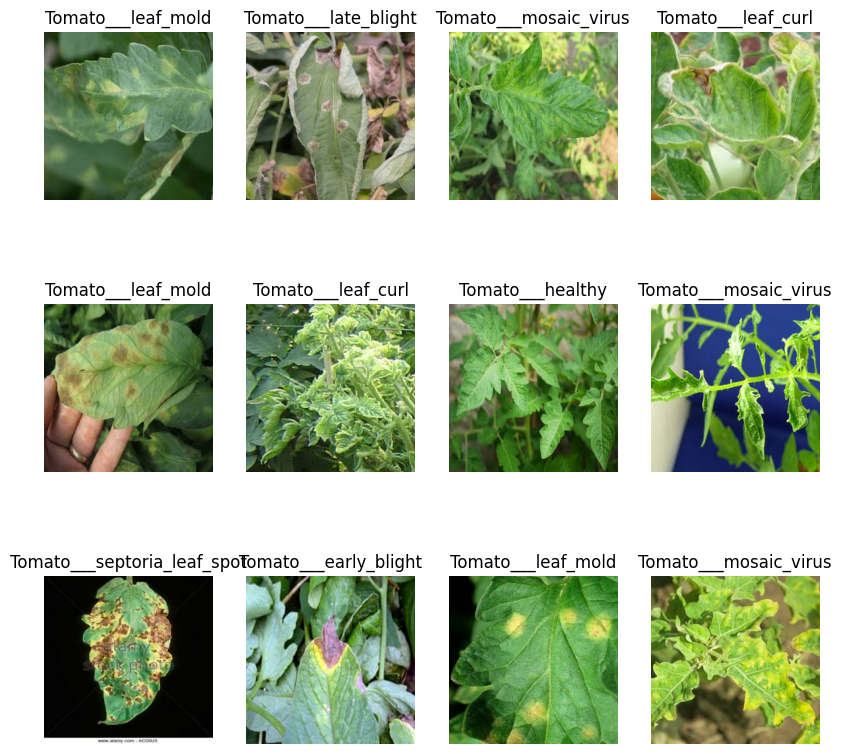

In [8]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [9]:
len(dataset)

29

In [10]:
train_size = 0.8
len(dataset)*train_size

23.200000000000003

In [11]:
train_ds = dataset.take(23)
len(train_ds)

23

In [12]:
test_ds = dataset.skip(23)
len(test_ds)

6

In [13]:
val_size=0.1
len(dataset)*val_size

2.9000000000000004

In [14]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [15]:
test_ds = test_ds.skip(6)
len(test_ds)

0

In [16]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)

    return train_ds, val_ds, ds.skip(train_size).skip(val_size)

In [17]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [18]:
len(train_ds)

23

In [19]:
len(val_ds)

2

In [20]:
len(test_ds)

4

In [21]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [22]:
import tensorflow as tf

resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),  # Updated
    tf.keras.layers.Rescaling(1./255)  # Updated
])


In [23]:

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),  # No need for 'experimental'
    layers.RandomRotation(0.2)
])

In [24]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [25]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 8

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [26]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (32, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (32, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (32, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (32, 4, 4, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (32, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 64)                    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 8)                     │             520 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 184,072 (719.03 KB)

 Trainable params: 184,072 (719.03 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [28]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 329s 719ms/step - accuracy: 0.2146 - loss: 2.0336 - val_accuracy: 0.2656 - val_loss: 1.9868
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 387ms/step - accuracy: 0.2692 - loss: 1.9792 - val_accuracy: 0.2656 - val_loss: 1.9701
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 356ms/step - accuracy: 0.2663 - loss: 1.9302 - val_accuracy: 0.2656 - val_loss: 1.9287
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 335ms/step - accuracy: 0.2616 - loss: 1.9528 - val_accuracy: 0.2656 - val_loss: 1.9111
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 377ms/step - accuracy: 0.2658 - loss: 1.9523 - val_accuracy: 0.2656 - val_loss: 1.9239
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 347ms/step - accuracy: 0.2775 - loss: 1.9216 - val_accuracy: 0.2656 - val_loss: 1.8977
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 350ms/step - accuracy: 0.2688 - loss: 1.9093 - val_accuracy: 0.2656 - val_loss: 1.8578
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 383ms/step - accuracy: 0.3120 - loss: 1.8592 - val_accuracy: 